# Logistic regression tutorial 

In [1]:
## Do **not** change this cell, and do **not** import
## any other modules anywhere in the notebook.
import numpy as np
import numpy.random as rn
from scipy import optimize, stats
import scipy.linalg as linalg
import matplotlib.pyplot as plt

%matplotlib inline

In this tutorial we're going to cover the basics behind logistic regression. For simplicity we will only consider the binary classification case, in which target variables are $y \in \{0,1\}$. 

In logistic regression, the probability of a data point $\boldsymbol x$ being of class 1 is given by

$$p(y = 1 | \boldsymbol x, \boldsymbol\theta) = \sigma (\boldsymbol x^\top \boldsymbol\theta) ~ ,$$

where $\sigma(z) = 1/(1+\exp(-z))$ is the _sigmoid_ function.

Combining this with a Bernoulli likelihood and summing over all datapoints $\{\boldsymbol x_i, y_i\}_{i=1}^N$ we end up with a negative log-likelihood function that looks like this:

$$-\log p(\boldsymbol y|\boldsymbol X, \boldsymbol\theta) = -\sum_i\left(y_i \log \sigma(\boldsymbol x_i^\top \boldsymbol\theta) + (1 - y_i) \log ( 1 - \sigma(\boldsymbol x_i^\top \boldsymbol\theta))\right)$$

You will see this expression in many other classification problems, especially in deep learning, where it's known as the _cross-entropy loss_.

Your goal in this tutorial is to learn how to perform inference over the parameters $\boldsymbol\theta$ in logistic regression, including point estimates $\boldsymbol\theta_{\mathrm{ML}}$ and $\boldsymbol\theta_{\mathrm{MAP}}$ and approximations to the posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$.

Let's do it.

## Maximum likelihood estimate

Let's start easy. First, let's generate a toy 1D binary dataset with two paramaters:

* A **jitter** parameter that controls how noisy the data are; and
* An **offset** parameter that controls the separation between the two classes.

In [2]:
# Data generation parameters
N = 50
D = 2
jitter = 0.7
offset = 1.2
np.random.seed(42)
# Generate the data
x = np.vstack([rn.normal(0, jitter, (N//2,1)), rn.normal(offset, jitter, (N//2,1))])
y = np.vstack([np.zeros((N//2, 1)), np.ones((N//2, 1))])
x_test = np.linspace(-2, offset + 2).reshape(-1,1)

# Make the augmented data matrix by adding a column of ones
x = np.hstack([np.ones((N,1)), x])
x_test = np.hstack([np.ones((N,1)), x_test])


Now on to the regression. First, let's code up the logistic log-likelihood as a separate function. This will come in handy.

**Task 1**

* Write a function to calculate the log-likelihood of a dataset given a value of $\boldsymbol\theta$.

In [3]:
## EDIT THIS FUNCTION
from numpy.linalg import inv
from numpy import linalg as LA
import scipy
def sigmoid (a):
        return (1+np.exp(-a))**(-1)
def log_likelihood(X, y, theta):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # theta: parameters (D x 1)
    # returns: log likelihood, scalar
    
    L = - np.inf ## <-- EDIT THIS LINE
    sigma=sigmoid(X @ theta)
    L=(y.T @ np.log(sigma) + (1-y).T @ np.log(1- sigma))
    return L

In [4]:
log_likelihood(x,y,np.array([1,2]))

array([-35.23792467])

Now it's time to optimize it to fit the maximum likelihood parameter,

$$\boldsymbol\theta_{\mathrm{ML}} = \mathrm{arg}_\theta \max p(\boldsymbol y | \boldsymbol X, \boldsymbol\theta)$$

For linear regression, the likelihood function had a closed-form minimum, which made our lives easy. Alas, that is not the case for logistic regression. We will have to resort to _numerical optimization_.

In the lectures you saw how to derive the gradient and all that jazz. For this tutorial you can do it that way, or any other way you want. The optimization is convex, so this should be easy peasy.

**Task 2**

* Write a function to optimize the log-likelihood function you've written above an obtain $\boldsymbol\theta_{\mathrm{ML}}$. Use any optimizer of your choice.

In [5]:
## EDIT THIS FUNCTION
def max_lik_estimate(X, y):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)
    
    N, D = X.shape
    theta_ml = np.zeros((D,1)) ## <-- EDIT THIS LINE
    fun = lambda w: -log_likelihood(X,y,w)
    theta_ml=scipy.optimize.minimize((fun),np.random.normal(size=(D,1)),method='BFGS',options={'gtol': 1e-10, 'disp': False})
    return theta_ml.x

In [6]:
theat2=max_lik_estimate(x,y)
print (theat2)

[-1.13633653  2.57591922]


**Task 3**

* Write a predict function to evaluate your estimate.

In [7]:
## EDIT THIS FUNCTION
def predict(X, theta):
    # Xtest: K x D matrix of test inputs
    # theta: D x 1 vector of parameters
    # returns: prediction of f(Xtest); K x 1 vector
    
    prediction = sigmoid(X @ theta)
    
    return prediction

With this we're in a good position to fit a logistic regression to our toy dataset and start visualising the results. Have a go.

1. Use the function you wrote above to estimate $\boldsymbol\theta_{\mathrm{ML}}$ on the toy dataset.
2. Visualize the results, including:
    1. The data $x$ and target labels $y$. 
    2. The labels predicted by the model.
    3. The probability assigned by the model, $\sigma(x\theta)$ as a function of $x$.

ac,curecy= 78.0 %


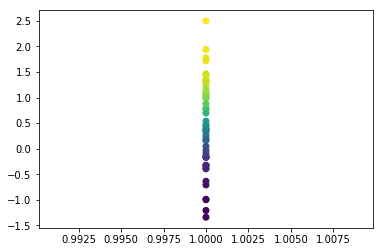

In [8]:
## ADD CODE HERE
# Fit and plot the logistic regression
## ADD CODE HERE
# Fit and plot the logistic regression
p=predict(x,theat2)
print ('ac,curecy= {} %'.format(100*np.sum(np.byte(p >= 0.5) == y.reshape(N,))/N))
plt.scatter(x[:,0],x[:,1],c=p)
# plt.plot(y,'o',label='logistic')
# plt.legend()

There you go! That should be a nice and easy fit. There are a few things we can start playing with at this point:

* Evaluate the performance of your model: plot the decision boundary, likelihood and accuracy on held-out test sets, etc.
* Write a gradient-based and a non-gradient-based optimizer. Do they arrive at the same result? Which one takes longer? Which one evaluates the likelihood function more times?

(Warning: if the plot looks odd and you get several warnings, it may be that the data is linearly separable and the sigmoid is saturating, leading to `np.log(0)` numerical problems. Add more noise and retry.)

## Bayesian logistic regression

### MAP estimate

Now let's move to Bayesian inference on the parameters $\boldsymbol\theta$. Let's put a prior on them. Because that's what we do. We put priors on things.

More specifically, let's use a Gaussian prior parametrized by a mean $\boldsymbol m$ and a variance $\boldsymbol S$:

$$\boldsymbol\theta \sim  \mathcal{N}(\boldsymbol m, \boldsymbol S)$$

Given that $\boldsymbol\theta_{\mathrm{ML}}$ had no analytical solution, it should really come as no surprise that $\boldsymbol\theta_{\mathrm{MAP}}$ doesn't either. That should be no problem for a machine learning expert like you:

**Task 4**

1. Write down the equation for the full unnormalized posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y) \propto p(\boldsymbol y | \boldsymbol\theta, \boldsymbol X) p(\boldsymbol\theta)$.
2. Write a separate function for it, as we did with the log-likelihood above.
3. Optimize it to find $\boldsymbol\theta_{\mathrm{MAP}}$ and use it to make predictions.

In [9]:
## EDIT THIS FUNCTION
def postior_log(X, y,m,S, theta):
    N, D = X.shape
    theta=theta.reshape(-1,1)
    log_theta=(theta-m).T @ inv(S) @ (theta-m)
#     print('log_theta.shape',log_theta.shape)
    theta_map = np.zeros((D,1)) ## <-- EDIT THIS LINE
    pl= log_theta + log_likelihood(X,y,theta)
    return pl
def map_estimate(X, y, m, S):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # m: D x 1 prior mean of parameters
    # S: D x D prior covariance of parameters
    # returns: maximum a posteriori parameters (D x 1)
    
    N, D = X.shape
    theta_map = np.zeros((D,1)) ## <-- EDIT THIS LINE
    fun = lambda w: -postior_log(X,y,m,S,w)
    theta_map=scipy.optimize.minimize(fun,np.random.normal(size=(D,1)),method='TNC',options={'gtol': 1e-100, 'disp': True})
    return theta_map.x

Now you can perform a similar model evaluation as you did before. How does your prior influence the MAP estimate and the model's performance?

th_map [-1.99136229  4.17167365]
accurecy= 98.0 %


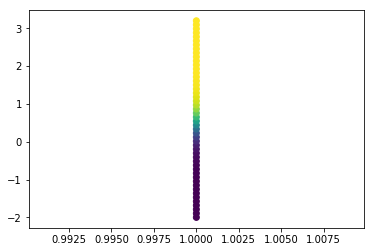

In [11]:
## ADD CODE HERE
# Fit and plot the MAP logistic regression estimate
# np.random.seed(50)
m = np.zeros((D, 1))
S = 5*np.eye(D)
th_map=map_estimate(x, y,m,S)
print('th_map',th_map)
p=predict(x_test,th_map)
print ('accurecy= {} %'.format(100*np.sum(np.byte(p >= 0.5) == y.reshape(N,))/N))
#print ('p',p)
plt.scatter(x_test[:,0],x_test[:,1],c=p)

### The Laplace approximation

As we have hinted above, in logistic regression the posterior distribution over $\boldsymbol\theta$ doesn't have an analytical solution. This is the first example in the course of _approximate Bayesian inference_: The exact posterior is analytically intractable so that we have to approximate it using one of various techniques. The one we'll use in this part of the tutorial is called the **Laplace approximation**.

In brief, **the Laplace approximation is a Gaussian centered at the peak of the pdf of interest with the same curvature**. Let's make this a bit more rigorous below.

Let's say we have a probability distribution $p(\boldsymbol z)$ we want to approximate. The distribution $p(\boldsymbol z)$ is of the form

$$p(\boldsymbol z) = \frac{1}{Z} \tilde{p}(\boldsymbol z) ~ ,$$

where $\tilde{p}(\boldsymbol z)$ is an unnormalized distribution that we can evaluate easily, but $Z$ is unknown. Formally, the Laplace approximation results from a second-order Taylor expansion of $\log \tilde{p}(\boldsymbol z)$ around $\boldsymbol  z_0$:

$$\log \tilde{p}(\boldsymbol z) \approx \log \tilde{p}(\boldsymbol z_0) + \frac{d}{d\boldsymbol z}\log \tilde{p}(\boldsymbol z)\Big|_{\boldsymbol z=\boldsymbol z_0}(\boldsymbol z -\boldsymbol  z_0) + \frac{1}{2}(\boldsymbol z-\boldsymbol z_0)^\top\frac{d^2}{d\boldsymbol z^2} \log \tilde{p}(\boldsymbol z)\Big|_{\boldsymbol z=\boldsymbol z_0}(\boldsymbol z-\boldsymbol z_0)$$

Now let's evaluate this expression at the mode of $p(\boldsymbol z)$ &ndash; which is the same as the mode of $\tilde{p}(\boldsymbol z)$. We define the mode $\boldsymbol z^*$ such that

$$\frac{d}{d\boldsymbol z} \tilde{p}(\boldsymbol z) \Big|_{\boldsymbol z = \boldsymbol z^*} = \boldsymbol 0 ~ .$$

At this point, the $\mathcal{O}(\boldsymbol z)$ term of the expansion vanishes and we are left with

$$\log \tilde{p}(\boldsymbol z) \approx \log \tilde{p}(\boldsymbol z^*) - \frac{1}{2}(\boldsymbol z-\boldsymbol z^*)^\top\boldsymbol A(\boldsymbol z-\boldsymbol z^*)$$

Or, equivalently,

$$\tilde{p}(\boldsymbol z) \approx \tilde{p}(\boldsymbol z^*) \exp\big(-\tfrac{1}{2}(\boldsymbol z - \boldsymbol z^*)^\top\boldsymbol A(\boldsymbol z - \boldsymbol z^*)\big) ~ ,$$

where

$$\boldsymbol A = - \frac{d^2}{d\boldsymbol z^2} \log \tilde{p}(\boldsymbol z)\Big|_{\boldsymbol z=\boldsymbol z^*} ~ .$$

And now this distribution we know how to normalize, because it's one of those Gaussians we know and love. By inspection, we can identify the mean and the covariance, and write down the Laplace approximation of $p(\boldsymbol z)$ as

$$q(\boldsymbol z) = \mathcal{N}(\boldsymbol z | \boldsymbol z^*, \boldsymbol A^{-1})$$

As an example, let's use the unnormalized distribution $\tilde{p}(z) = x e^{-x/2}$. When normalized properly, this is in fact the $\chi^2$ distribution with $k=4$ degrees of freedom. Have a go yourself:

1. Plot $p(z)$.
2. Take the first derivative of $\tilde{p}(z)$ (or the first derivative of its log), and find its maximum $z^*$ analytically.
3. In the same plot, draw a vertical line at $z = z^*$ to verify you got the right answer.
4. Take the second derivative of $\log \tilde{p}(z)$ and evaluate it at $z^*$.
5. Plot the corresponding Gaussian $q(z)$ and verify the approximation looks reasonable.

**Task 5**

* Write a function that evaluates the Laplace approximation $q(z)$.

In [10]:
## EDIT THIS FUNCTION
def laplace_q(z):
    # z: double array of size (T,)
    # returns: array with Laplace approximation q evaluated
    #          at all points in z
    return stats.multivariate_normal.pdf(z,2,4)

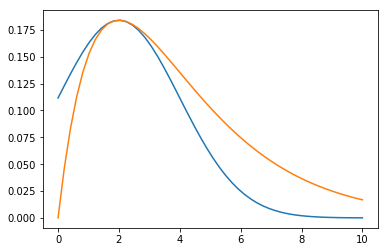

In [11]:
## ADD CODE HERE
# Find the Laplace approximation of x*exp(-x/2) with pen and paper and then plot it.
z = np.linspace(0,10)
p = stats.chi2.pdf(z, 4)
c=laplace_q(z)
c = c/c.max() * p.max()
plt.plot(z,c)
plt.plot(z, p)
# plt.xlim(1.8, 2.2)
# plt.ylim(.125, 2)

### Bayesian logistic regression (for real this time)

Now we have obtained the mode (peak) of the posterior through the MAP estimate above, it's time to go all the way and calculate the posterior over $\boldsymbol\theta$. However, as we mentioned above the posterior doesn't have an analytical form, so we'll use &ndash; you guessed it &ndash; the Laplace transform.

**Task 6**

* Write a function, based on your previous code, that will calculate the Laplace approximation $q(\boldsymbol\theta)$ of the true posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$ and return the mean and variance of $q$.

To visualize the behavior and the diversity of $q$, draw a number $j = 1, ..., J$ of samples $\boldsymbol\theta_j \sim q(\boldsymbol\theta)$. For each sample, plot its predicted class probabilities $\sigma(x \boldsymbol\theta_j)$.

_Hint_: the extension of the Laplace approximation to multivariate distributions is straightforward, and in this case the variance of the Gaussian is the Hessian of the negative log likelihood $\boldsymbol A = - \nabla_\theta \nabla_\theta \log p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$.

In [12]:
## EDIT THIS FUNCTION

def Hessian(X,Y, theta):
    return X.T @ (np.identity(X.shape[0])*sigmoid((X @ theta) - Y)) @ X

def get_posterior(X, y, m, S):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # m: D x 1 prior mean of parameters
    # S: D x D prior covariance of parameters
    # returns: maximum a posteriori parameters (D x 1)
    #          covariance of Laplace approximation (D x D)

    mu_post = map_estimate(X, y, m, S)#np.zeros((D, 1)) ## <-- EDIT THESE LINES
    S_post  = np.linalg.inv(Hessian(X,y,mu_post) + np.linalg.inv(S))#np.eye(D)

    return mu_post, S_post

[[ 0.25621289 -0.1440992 ]
 [-0.1440992   0.10139411]]


/usr/lib/python3/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


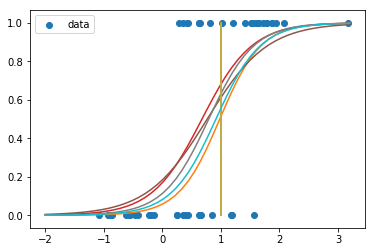

In [13]:
## ADD CODE HERE
# Calculate the Laplace approximation of the posterior for theta, 
# draw a few samples and plot the corresponding likelihood functions 
# for each one.
m = np.zeros((D, 1))
S = 5*np.eye(D)
nb_samples = 5

theta_map, S_post = get_posterior(x, y, m, S)
print(S_post)
# print ('theta_map',theta_map)
# print ('S_post',S_post)
plt.scatter(x[:,1], y,label='data')
for i in range(nb_samples):
    t=np.random.multivariate_normal(theta_map.ravel(),S_post)
#     t=stats.multivariate_normal.pdf(x,theta_map.ravel(),S_post)
    plt.plot(x_test,predict(x_test,t))#,label='prediction {}'.format(i)) ## <--EDIT THIS LINE
plt.legend()
plt.show()

## Comparing posterior approximations

The Laplace approximation is part of a family of methods known as _deterministic approximate inference_. In addition, there's another set of methods known as _stochastic approximate inference_ which, as you can guess includes most of the sampling techniques you have studied.

You must be an expert in sampling by now. Let's actually go and check whether this Laplace approximation we just made is legit.

* What sampling methods do you know to sample from an unnormalized distribution?

For example, let's try the Metropolis algorithm.

1. Write a proposal function to move in $\boldsymbol\theta$-space.
2. Write a function to accept or reject new proposals based on the Metropolis criterion.
3. Write a loop and run the Markov chain for a few thousand iterations.
4. Check that the sampling worked: did the Markov chain mix properly? What's the acceptance rate? How does it depend on the proposal function?

**Task 7**

* Write a function to sample from the true posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$.

Finally, let's plot the results and see if both inference methods arrive at roughly the same posterior.

In the same axis, plot

* The histogram pdf of the MCMC samples (you may want to look at the `density` option in `plt.hist`); and
* The Laplace posterior.

Make one plot for the intercept ($\theta_0$) and one for the slope ($\theta_1$). What do they look like? Do they match? What kinds of posteriors do you think the Laplace approximation will be good or bad at approximating?

In [14]:
## EDIT THIS FUNCTION
def metropolis_algorithim(x_intial,S,nb_iter,prop_fn):
    np.random.seed
    sample = [x_intial]
    aceptence_rate = 0
    for i in range(nb_iter):
        q_cand = np.random.multivariate_normal(x_intial, S)#.reshape(-1,1)
#         q_cand=q_cand.reshape(-1,1)
        q_back = np.random.multivariate_normal(q_cand, S)#.reshape(-1,1)
        u = np.random.uniform()
#         print('q_cand.shape',q_cand.shape)
#         print('q_back.shape',q_back.shape)
#         p_cand=10*stats.multivariate_normal.pdf(q_cand,m.reshape(-1,1),S)
#         p_back=10*stats.multivariate_normal.pdf(x_intial,m.reshape(-1,1),S)
        p_cand = prop_fn(q_cand)
        p_back = prop_fn(x_intial)
        if np.all((p_cand*q_back) >= u*(q_cand*p_back)):
            sample.append(q_cand)
            x_intial = q_cand
            aceptence_rate += 1
        else:
            sample.append(x_intial)
    return np.array(sample), aceptence_rate/nb_iter

def prop_fn(x,m,S,k=10):  
    return 10*stats.multivariate_normal.pdf(x,m,S)

def posterior_sample(X, y, m, S, nb_iter):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # m: D x 1 prior mean of parameters
    # S: D x D prior covariance of parameters
    # returns: nb_iter x D matrix of posterior samples
    N,D = X.shape
    
    mu_post = map_estimate(X, y, m.reshape(-1,1), S)#np.zeros((D, 1)) ## <-- EDIT THESE LINES
    S_post  = np.linalg.inv(Hessian(X,y,mu_post))#np.eye(D)
    
    fun = lambda x: prop_fn(x ,mu_post ,S_post)
    
    D = X.shape[1]
    samples_MCMC, ac_rate = metropolis_algorithim(mu_post + 2,0.01*np.eye(D),nb_iter,fun) #np.zeros((nb_iter, D))
#     print('acceptence rate: ', ac_rate*100)
    
    return samples_MCMC

acceptence rate:  25.28


(array([8.000e+00, 5.000e+00, 5.000e+00, 7.000e+00, 1.100e+01, 2.700e+01,
        9.000e+00, 3.960e+02, 3.161e+03, 6.372e+03]),
 array([0.00540387, 0.00564921, 0.00589455, 0.00613989, 0.00638523,
        0.00663057, 0.00687591, 0.00712125, 0.00736659, 0.00761193,
        0.00785727]),
 <a list of 10 Patch objects>)

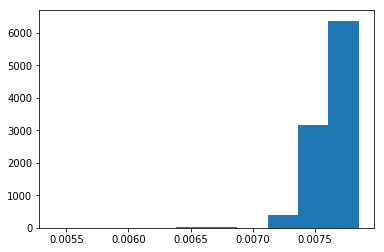

In [15]:
## ADD CODE HERE
# Plot a histogram of the MCMC posterior samples and the
# analytical expression for the Laplace posterior. If
# everything went well, the peaks should coincide and
# their widths should be comparable.
x_int=th_map#.reshape(-1,1)
# var=200*S_post
var=20*np.eye(D)

nb_iter = 10000
samples = posterior_sample(x, y, x_int, var, nb_iter)
y1=stats.multivariate_normal.pdf(samples,np.zeros(D),var).reshape(-1,1)
plt.hist(y1)

Et violà! Now you're an expert in logistic regression. (Wait, I think that's a big violin. I meant to say: et voilà!)

Now we can visualize the posterior we can play around with the data and the inference parameters:

* Play around with the data generation process. What happens as you increase/decrease $N$ and the jitter parameter?
* What does the joint posterior look like? Make a visualization of the MCMC and Laplace approximations in the $(\theta_0, \theta_1)$ plane.
* What happens if the model is misspecified? Take out the intercept term in the model (i.e., remove the column of ones in $\boldsymbol X$), but set the `offset` in the data generation process to non-zero. What happens to the posterior and its Laplace approximation?


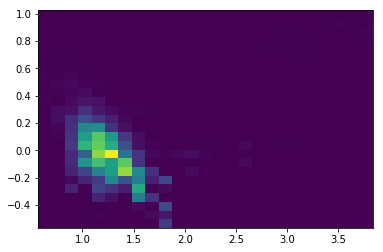

In [16]:
plt.hist2d(samples[:,1],samples[:,0], bins=25);